In [9]:
from copy import deepcopy

import numpy as np

import ai.config as config
from model.game import Action
from ai.agent import AlphaZero


import ai.utils as ut
import ai.treesearch as ts

In [53]:
class RejectedActionError(Exception):
    pass

In [46]:
import time
import random

from IPython.display import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf
import plotly.graph_objects as go

from ai.model import NeuralNetwork
from model.international_game import InternationalGame

In [47]:
init_notebook_mode(connected=True)
cf.go_offline()
np.random.seed(5)

In [48]:
action_space_shape = len(ut.get_action_space(10, 10))
current_model = NeuralNetwork(config.REG_CONST, config.LEARNING_RATE, 
                                      (10,10,25), action_space_shape, config.HIDDEN_CNN_LAYERS)

In [49]:
currentAgent = AlphaZero(config.MCTS_SIMS)

In [105]:
def self_play():
    pass

In [18]:


class PlayGround:
    def __init__(self):
        self.action_space_shape = len(get_action_space(10, 10))
        self.current_model = NeuralNetwork(config.REG_CONST, config.LEARNING_RATE, 
                                      (10,10,25),   self.action_space_shape, config.HIDDEN_CNN_LAYERS)

        #self.best_model = NeuralNetwork(config.REG_CONST, config.LEARNING_RATE, 
                                   #(10,10,25),   self.action_space_shape, config.HIDDEN_CNN_LAYERS)
        
        self.best_model.model.set_weights(self.current_model.model.get_weights())
        self.exp = []
        self.turn = []
        
        self.fig = go.FigureWidget()
        self.fig.update_layout(xaxis_title="Turn", yaxis_title='Expected value')
        #self.fig.add_scatter(fill='tozeroy')
        self.fig.add_scatter()

    def plot_figure(self):
        display(self.fig)
        
    def update_plot(self):
        with self.fig.batch_update():
            self.fig.data[0].x = self.turn
            self.fig.data[0].y = self.exp
            
    def apply_and_update(self, game, playing_agent: AlphaZero, other_agent: AlphaZero, action: Action, action_id: int):
        print(game.grid)
        print(action)
        if not game.is_legal_action(action):
            print(game.current_turn)
            actions = game.get_all_possible_actions()
            for act in actions:
                print(act)
            raise RejectedAction("your fucked bro!")
        game.apply_action(action)
        playing_agent.update_root(action_id)
        if other_agent is not None:
            other_agent.update_root(action_id)
            
        #return sample_builder

    def self_play(self):
        current_Agent = AlphaZero(config.MCTS_SIMS, config.CPUCT, self.current_model, pov=0, name="Current AlphaZero")
        
        game = InternationalGame(1, None, None, None)
        sample_builder = SampleBuilder()

        for ep in range(config.EPISODES):
            game.init()
            current_Agent.build_mcts(StateStack(deepcopy(GameState(game))))

            turn = 1
            player: AlphaZero = current_Agent

            while not game.end():
                player.pov = game.currentTurn
                tau = 1 if turn < config.TURNS_UNTIL_TAU0 else 0
                try:
                    action, action_id, state_stack, value, pi = player.train_act(tau)
                except KeyError as e:
                    print(e)
                    print(player.mcts.root.edges)

                if player.pov == 1:
                    self.turn.append(turn)
                    self.exp.append(value)
                self.apply_and_update(game, current_Agent, None, action, action_id)
                self.update_plot()
                sample_builder.commit_move(state_stack, pi)
                turn += 1
                print('*', end='')

            value = evaluate(game)
            sample_builder.commit_sample(value, config.MAXIMIZER)

        return sample_builder
    
    def fit(self, sample_builder:SampleBuilder):
        for i in range(10):
            minibatch = random.sample(sample_builder.samples, min(config.BATCH_SIZE, len(sample_builder.samples)))
            training_states = np.array([row['state'].get_deep_representation_stack() for row in minibatch])
            training_targets = {'value_head': np.array([row['value'] for row in minibatch]),
                                'policy_head': np.array([row['policy'] for row in minibatch])}

            ret = self.current_model.fit(training_states, training_targets, epochs=config.EPOCHS, verbose=1, validation_split=0, batch_size = 32)

In [19]:
playground = PlayGround()

In [13]:
#playground.plot_figure()

In [20]:
try:
    playground.self_play()
except RejectedAction as e:
    print(e)

     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  B  . 
 3|  .  B  .  B  .  B  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  B  . 
 5|  .  .  .  .  .  .  .  .  .  . 
 6|  .  .  .  .  .  .  .  .  .  . 
 7|  .  W  .  W  .  W  .  W  .  W 
 8|  W  .  W  .  W  .  W  .  W  . 
 9|  .  W  .  W  .  W  .  W  .  W 
10|  W  .  W  .  W  .  W  .  W  . 

(7,6)------->>>(6,5)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  B  . 
 3|  .  B  .  B  .  B  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  B  . 
 5|  .  .  .  .  .  .  .  .  .  . 
 6|  .  .  .  .  W  .  .  .  .  . 
 7|  .  W  .  W  .  .  .  W  .  W 
 8|  W  .  W  .  W  .  W  .  W  . 
 9|  .  W  .  W  .  W  .  W  .  W 
10|  W  .  W  .  W  .  W  .  W  . 

(4,9)------->>>(5,8)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  B  . 
 3|  .  B  .  B  .  B  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  .  . 
 5|  .  .

*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  .  . 
 3|  .  .  .  B  .  B  .  B  .  . 
 4|  .  .  .  .  .  .  B  .  B  . 
 5|  .  .  .  .  .  .  .  B  .  . 
 6|  B  .  .  .  W  .  .  .  .  . 
 7|  .  .  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  .  .  W  .  W  . 
 9|  .  W  .  W  .  .  .  W  .  W 
10|  W  .  W  .  W  .  W  .  W  . 

(3,4)------->>>(4,3)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  .  . 
 3|  .  .  .  .  .  B  .  B  .  . 
 4|  .  .  B  .  .  .  B  .  B  . 
 5|  .  .  .  .  .  .  .  B  .  . 
 6|  B  .  .  .  W  .  .  .  .  . 
 7|  .  .  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  .  .  W  .  W  . 
 9|  .  W  .  W  .  .  .  W  .  W 
10|  W  .  W  .  W  .  W  .  W  . 

(9,4)------->>>(8,5)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  B  .  B 
 2|  B  .  B  .  B  .  B  .  .  . 
 3|  .  .  .  .  .  B  .  B  .  . 
 4|  .  .  B  .  .  .  B  .  B  . 
 5|  .  

*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  .  .  B 
 2|  .  .  B  .  .  .  .  .  B  . 
 3|  .  .  .  B  .  B  .  B  .  . 
 4|  B  .  .  .  .  .  B  .  B  . 
 5|  .  B  .  .  .  .  .  B  .  . 
 6|  B  .  .  .  W  .  .  .  .  . 
 7|  .  W  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  W  .  W  .  W  . 
 9|  .  .  .  W  .  .  .  W  .  W 
10|  W  .  .  .  W  .  .  .  W  . 

(10,1)------->>>(9,2)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  B  .  .  .  B 
 2|  .  .  B  .  .  .  .  .  B  . 
 3|  .  .  .  B  .  B  .  B  .  . 
 4|  B  .  .  .  .  .  B  .  B  . 
 5|  .  B  .  .  .  .  .  B  .  . 
 6|  B  .  .  .  W  .  .  .  .  . 
 7|  .  W  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  W  .  W  .  W  . 
 9|  .  W  .  W  .  .  .  W  .  W 
10|  .  .  .  .  W  .  .  .  W  . 

(1,6)------->>>(2,7)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  B  .  .  .  .  .  B 
 2|  .  .  B  .  .  .  B  .  B  . 
 3|  .  .  .  B  .  B  .  B  .  . 
 4|  B  .  .  .  .  .  B  .  B  . 
 5|  . 

*     1  2  3  4  5  6  7  8  9  10
 1|  .  B  .  .  .  .  .  .  .  B 
 2|  .  .  .  .  .  .  .  .  .  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  B  . 
 5|  .  B  .  .  .  B  .  B  .  W 
 6|  B  .  W  .  W  .  .  .  W  . 
 7|  .  W  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  W  .  W  .  .  . 
 9|  .  .  .  W  .  .  .  W  .  W 
10|  .  .  .  .  W  .  .  .  .  . 

(1,2)------->>>(2,3)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  B 
 2|  .  .  B  .  .  .  .  .  .  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  B  . 
 5|  .  B  .  .  .  B  .  B  .  W 
 6|  B  .  W  .  W  .  .  .  W  . 
 7|  .  W  .  W  .  W  .  W  .  W 
 8|  .  .  W  .  W  .  W  .  .  . 
 9|  .  .  .  W  .  .  .  W  .  W 
10|  .  .  .  .  W  .  .  .  .  . 

(9,10)------->>>(8,9)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  B 
 2|  .  .  B  .  .  .  .  .  .  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  B  .  B  .  B  .  B  . 
 5|  . 

*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  . 
 2|  .  .  .  .  .  .  .  .  B  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  .  .  B  .  .  .  B  . 
 5|  .  .  .  .  .  W  .  .  .  W 
 6|  B  .  .  .  .  .  W  .  W  . 
 7|  .  W  .  B  .  .  .  W  .  . 
 8|  .  .  W  .  W  .  .  .  W  . 
 9|  .  .  .  W  .  .  .  W  .  . 
10|  .  .  .  .  W  .  .  .  .  . 

(7,4)------->>>(9,6)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  . 
 2|  .  .  .  .  .  .  .  .  B  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  .  .  B  .  .  .  B  . 
 5|  .  .  .  .  .  W  .  .  .  W 
 6|  B  .  .  .  .  .  W  .  W  . 
 7|  .  W  .  .  .  .  .  W  .  . 
 8|  .  .  W  .  .  .  .  .  W  . 
 9|  .  .  .  W  .  B  .  W  .  . 
10|  .  .  .  .  W  .  .  .  .  . 

(10,5)------->>>(8,7)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  . 
 2|  .  .  .  .  .  .  .  .  B  . 
 3|  .  B  .  B  .  .  .  B  .  B 
 4|  B  .  .  .  B  .  .  .  B  . 
 5|  . 

*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  .  .  . 
 2|  .  .  .  .  .  .  W  .  B  . 
 3|  .  .  .  .  .  .  .  .  .  B 
 4|  .  .  B  .  .  .  W  .  .  . 
 5|  .  B  .  .  .  .  .  .  .  W 
 6|  B  .  .  .  W  .  .  .  W  . 
 7|  .  W  .  .  .  .  .  W  .  W 
 8|  .  .  W  .  .  .  .  .  .  . 
 9|  .  .  .  .  .  .  .  W  .  . 
10|  .  .  .  .  .  .  .  .  .  . 

(2,7)------->>>(1,8)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  W  .  . 
 2|  .  .  .  .  .  .  .  .  B  . 
 3|  .  .  .  .  .  .  .  .  .  B 
 4|  .  .  B  .  .  .  W  .  .  . 
 5|  .  B  .  .  .  .  .  .  .  W 
 6|  B  .  .  .  W  .  .  .  W  . 
 7|  .  W  .  .  .  .  .  W  .  W 
 8|  .  .  W  .  .  .  .  .  .  . 
 9|  .  .  .  .  .  .  .  W  .  . 
10|  .  .  .  .  .  .  .  .  .  . 

(4,3)------->>>(5,4)
*     1  2  3  4  5  6  7  8  9  10
 1|  .  .  .  .  .  .  .  W  .  . 
 2|  .  .  .  .  .  .  .  .  B  . 
 3|  .  .  .  .  .  .  .  .  .  B 
 4|  .  .  .  .  .  .  W  .  .  . 
 5|  .  

In [259]:
def calc_expected_score(old_rate, opp_rate):
    res = 1 + 10**((opp_rate - old_rate) / 400)
    return 1 / res

def calc_K(rate):
    if rate < 2100:
        return 32
    if 2200 <= rate < 2400:
        return 24
    return 16

def calc_score(player_number, outcome):
    if outcome == 0:
        return 0.5
    if outcome == player_number:
        return 1
    return 0

def calc_new_rate(player1_rate, player2_rate, outcome):
    player1_rate += calc_K(player1_rate) * (calc_score(1, outcome) - calc_expected_score(player1_rate, player2_rate))
    player2_rate += calc_K(player2_rate) * (calc_score(2, outcome) - calc_expected_score(player2_rate, player1_rate))
    return int(player1_rate), int(player2_rate)

In [253]:
player_score = calc_score(1, 2) + calc_score(1, 0) + calc_score(1, 1) + calc_score(1, 1) + calc_score(1, 2)
player_expected_score = calc_expected_score(1613, 1609) + calc_expected_score(1613, 1477) + calc_expected_score(1613, 1388) + calc_expected_score(1613, 1586) + calc_expected_score(1613, 1720)
player_new_rate = 1613 + calc_K(1613) * (player_score - player_expected_score)
print(player_new_rate)
#1601

1601.2698768627572


In [254]:
import numpy as np
import random
        

In [454]:
import pandas as pd
df = pd.read_csv('data/usersData.csv')
df.index.name = 'player_id'
df

,signup_date,rate,international_win,international_lose,international_draw,turkish_win,turkish_lose,turkish_draw,sessions,longest_session
player_id,,,,,,,,,,


In [455]:
import datetime
from dateutil.relativedelta import relativedelta

for i in range(0, 100):
    signup_date = (datetime.datetime.now() - relativedelta(days=random.randint(1, 30), months=random.randint(1, 3))).date()
    df = df.append({
        'signup_date':signup_date,
        'rate':1600,
        'international_win':1,
        'international_lose':1,
        'international_draw':1,
        'turkish_win':1,
        'turkish_lose':1,
        'turkish_draw':1,
        'sessions':1,
        'longest_session':30,
    },ignore_index=True)
df.head()

,signup_date,rate,international_win,international_lose,international_draw,turkish_win,turkish_lose,turkish_draw,sessions,longest_session
0,2020-01-30,1600,1,1,1,1,1,1,1,30
1,2020-03-14,1600,1,1,1,1,1,1,1,30
2,2020-04-11,1600,1,1,1,1,1,1,1,30
3,2020-02-20,1600,1,1,1,1,1,1,1,30
4,2020-04-09,1600,1,1,1,1,1,1,1,30


In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   signup_date         100 non-null    object
 1   rate                100 non-null    object
 2   international_win   100 non-null    object
 3   international_lose  100 non-null    object
 4   international_draw  100 non-null    object
 5   turkish_win         100 non-null    object
 6   turkish_lose        100 non-null    object
 7   turkish_draw        100 non-null    object
 8   sessions            100 non-null    object
 9   longest_session     100 non-null    object
dtypes: object(10)
memory usage: 7.9+ KB


In [501]:
indices = [i for i in range(0, 100)]


In [459]:
winningside = indices[0: 50]
for idx in winningside:
    indices.remove(idx)
print(indices)

[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [461]:
lossingside = indices

In [504]:


def modify(index, df, new_rate, outcome, player_number, mode):
    df.loc[index, 'rate'] = max(new_rate, 150)
    if mode == 1:
        if outcome == player_number:
            df.loc[index, 'international_win'] += 1
        elif outcome == 0:
            df.loc[index, 'international_draw'] += 1
        else:
            df.loc[index, 'international_lose'] += 1
    else:
        if outcome == player_number:
            df.loc[index, 'turkish_win'] +=  1
        elif outcome == 0:
            df.loc[index, 'turkish_draw'] += 1
        else:
            df.loc[index, 'turkish_lose'] += 1
            
for i in range(10000):
    if i % 3:
        df = df.sort_values('rate').reset_index().drop('index', axis = 1)        
    mode = 1
    """    
    player1_idx = indices[i % 99]
    player2_idx = indices[i % 99 + 1]

    player1_rate = df['rate'].iloc[player1_idx]
    player2_rate = df['rate'].iloc[player2_idx]
    if player1_rate < player2_rate:
        player1_rate, player2_rate = player2_rate, player1_rate
        player1_idx, player2_idx = player2_idx, player1_idx
    dif = player1_rate - player2_rate
    if dif >= 10:
        outcome = 1
    else:
        if 10 < dif < 20:
            outcome = random.choices([1, 2], [0.65, 0.35])[0]
        else:
            outcome = random.choices([1, 2])[0]
    """    

    player1_idx = indices[i % 99]
    player2_idx = indices[i % 99 + 1]

    player1_rate = df['rate'].iloc[player1_idx]
    player2_rate = df['rate'].iloc[player2_idx]
    
    #index = indices[i % 99] if player1_rate > player2_rate else indices[i % 99 + 1]

    outcome = 1
    
    player1_rate, player2_rate = calc_new_rate(player1_rate, player2_rate, outcome)
    modify(player1_idx, df, player1_rate, outcome, 1, mode)
    modify(player2_idx, df, player2_rate, outcome, 2, mode)

In [541]:
df = pd.read_csv('data/users v3.csv')
df

,signup_date,rate,category,international_win,international_lose,international_draw,turkish_win,turkish_lose,turkish_draw
0,2020-01-27,1664,Class B,50,44,1,58,60,1
1,2020-01-27,1440,Class C,46,60,1,47,43,1
2,2020-01-27,1504,Class C,46,60,1,51,43,1
3,2020-01-29,1680,Class B,63,56,1,45,47,1
4,2020-01-30,1488,Class C,50,58,1,47,46,1
...,...,...,...,...,...,...,...,...,...
95,2020-04-21,1472,Class C,49,46,1,46,57,1
96,2020-04-21,1632,Class B,55,57,1,51,47,1
97,2020-04-23,1903,Class A,51,54,1,63,41,1
98,2020-04-23,1872,Class A,50,46,1,56,43,1


In [522]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [548]:
import plotly.graph_objects as go
import plotly.express as px

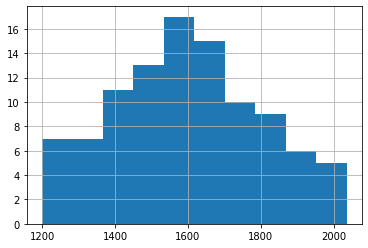

In [542]:
df['rate'].hist()

In [657]:
def players_category_histogram(df):
    categories = ['novices',
                  'Class D',
                  'Class C',
                  'Class B',
                  'Class A',
                  'Expert',
                  'Candidate Master',
                  'Master',
                  'International Master',
                  'Grand Master']
    traces = []
    for cat in reversed(categories):
        trace = go.Histogram(x = df[df.category == cat].rate,
                             marker = dict(line=dict(color='rgb(0,0,0)',
                                                     width=1.5)),
                             name = cat)
        traces.append(trace)

    layout = dict(barmode = 'overlay',
                  title = 'Users ratings',
                  xaxis= dict(title= 'Ratings',
                              ticklen= 5,
                              zeroline= False, 
                              ticks="inside"),
                  yaxis = dict(title = 'Count',
                               ticklen = 5,
                               zeroline = False,
                               ticks="outside"))
    return {'data': traces, 'layout': layout}

In [658]:
iplot(players_category_histogram(df))

In [571]:
# create trace1 
trace1 = go.Scatter(
                y = df.rate,
                x = df.index,
                mode = 'markers',
                marker = dict(color = 'rgba(31, 119, 180, 0.8)',
                              line=dict(color='rgb(0,0,0)',width=1.5))
            )
layout = dict(barmode = 'group',title = 'Users ratings',
             xaxis= dict(title= 'User ID',ticklen= 5,zeroline= False, ticks="inside"), 
             yaxis = dict(title = 'Rate', ticklen = 5, zeroline = False, ticks="outside"))
data = [trace1]

fig = {'data': data, 'layout': layout}
iplot(fig)

In [526]:
# create trace1 
trace1 = go.Scatter(
                y = df.international_win,
                x = df.rate,
                mode = 'markers',
                marker = dict(color = 'rgba(31, 119, 180, 0.8)',
                              line=dict(color='rgb(0,0,0)',width=1.5))
            )
layout = dict(title = 'International wins vs Rating',
             yaxis= dict(title= 'International wins',ticklen= 5,zeroline= False, ticks="inside"), 
             xaxis = dict(title = 'Rating', ticklen = 5, zeroline = False, ticks="outside"))
data = [trace1]

fig = {'data': data, 'layout': layout}
iplot(fig)

In [527]:
# create trace1 
trace1 = go.Scatter(
                y = (df.international_win + df.turkish_win) / (df.international_lose + df.turkish_lose + df.international_draw + df.turkish_draw),
                x = df.rate,
                mode = 'markers',
                marker = dict(color = 'rgba(31, 119, 180, 0.8)',
                              line=dict(color='rgb(0,0,0)',width=1.5))
            )
layout = dict(title = 'Winning rate vs Rating',
             yaxis= dict(title= 'Winning rate',ticklen= 5,zeroline= False, ticks="inside"), 
             xaxis = dict(title = 'Rating', ticklen = 5, zeroline = False, ticks="outside"))
data = [trace1]

fig = {'data': data, 'layout': layout}
iplot(fig)

In [530]:
# create trace1 
trace1 = go.Histogram(
                x = df.signup_date,
                marker = dict(color = 'rgba(31, 119, 180, 0.8)',
                              line=dict(color='rgb(0,0,0)',width=1.5))
            )
layout = dict(barmode = 'group',title = 'Registration',ِ
             xaxis= dict(title= 'Date',ticklen= 5,zeroline= False, ticks="inside"), 
             yaxis = dict(title = 'Users', ticklen = 5, zeroline = False, ticks="outside"))
data = [trace1]

fig = {'data': data, 'layout': layout}
iplot(fig)

In [531]:
def classify(rate):
    if rate < 1200:
        return 'novices'
    if 1200 <= rate < 1400:
        return 'Class D'
    if 1400 <= rate < 1600:
        return 'Class C'
    if 1600 <= rate < 1800:
        return 'Class B'
    if 1800 <= rate < 2000:
        return 'Class A'
    if 2000 <= rate < 2200:
        return 'Expert'
    if 2200 <= rate < 2300:
        return 'Candidate Master'
    if 2300 <= rate < 2400:
        return 'Master'
    if 2400 <= rate < 2500:
        return 'International Master'
    if rate >= 2500:
        return 'Grand Master'

In [644]:
np.array(df.rate), np.array(df.category)


LabelEncoder()

In [645]:
from sklearn.preprocessing import LabelBinarizer
label_Binarizer = LabelBinarizer()
label_Binarizer.fit(np.array(df.category))

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [653]:
label_Binarizer.transform(['Class A'])

array([[1, 0, 0, 0, 0]])